## **Data Neural Network on Medical Image Classification**
The dataset contains two kinds of chest X-ray Images: NORMAL and PNEUMONIA, which are stored in two folders.
In the PNEUMONIA folder, two types of specifc PNEUMONIA can be recognized by the fle name: BACTERIA and VIRUS.

# **Importing Libraries**

In [ ]:
import numpy as np 
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import os
train_data_dir = "/content/drive/MyDrive/chest_xray/train"
val_data_dir = "/content/drive/MyDrive/chest_xray/val"
test_data_dir = "/content/drive/MyDrive/chest_xray/test"

### 1. Exploratory Data Analysis 

The first step in our project is conducting an exploratory analysis, and look what the data has to offer. We start with loading in the data to check the images to get an idea about the differences in the x-ray imagaes between the 2 classes. All the data is stored online in kaggle.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Normal X-Rays From Validation Set: 1342 
Pneumonia X-Rays From Validation Set: 3141 


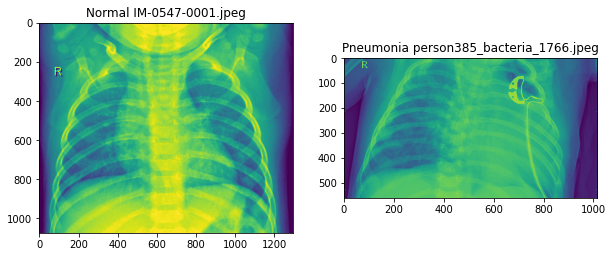

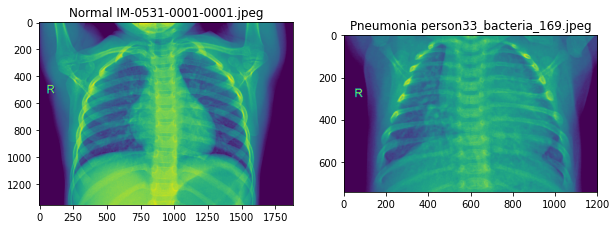

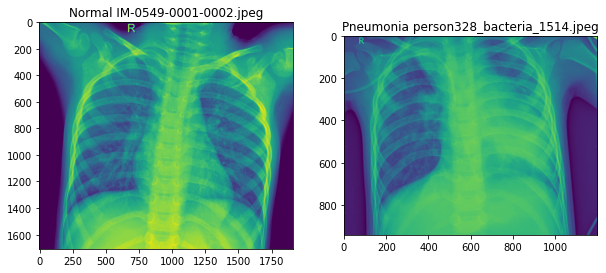

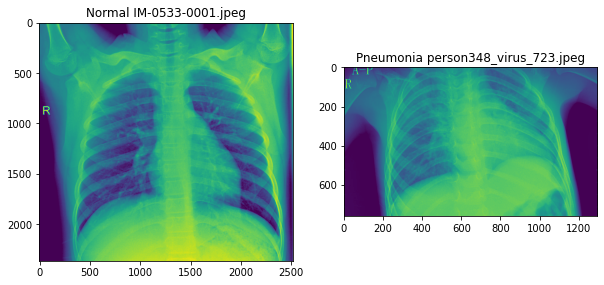

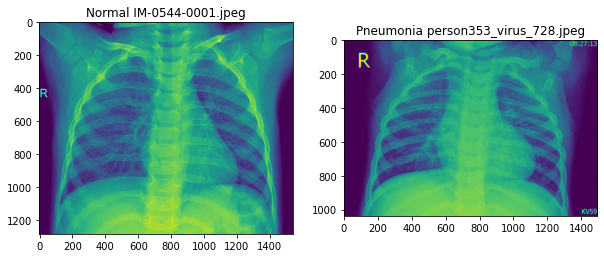

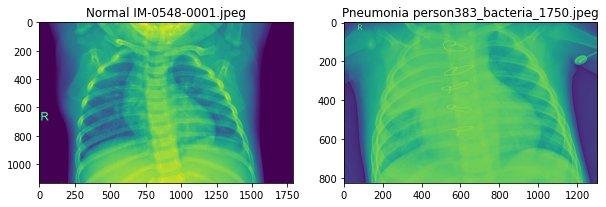

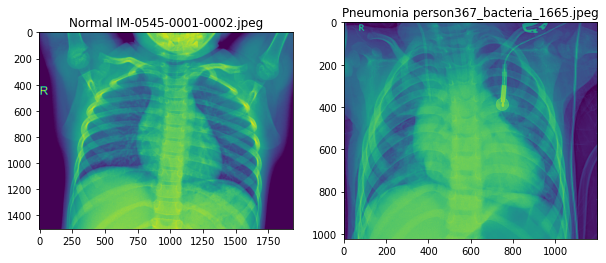

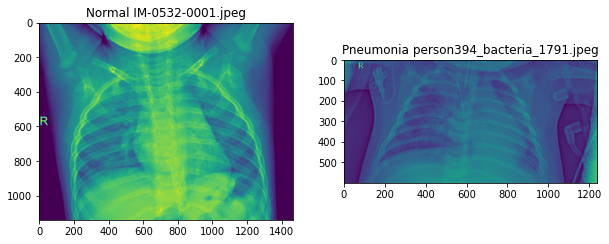

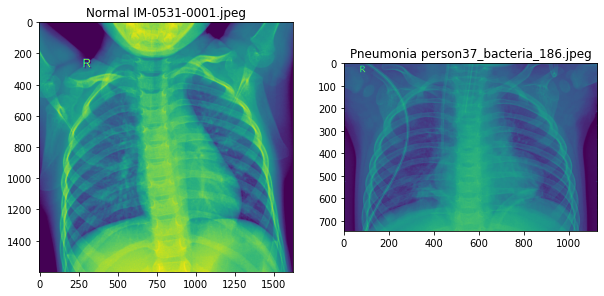

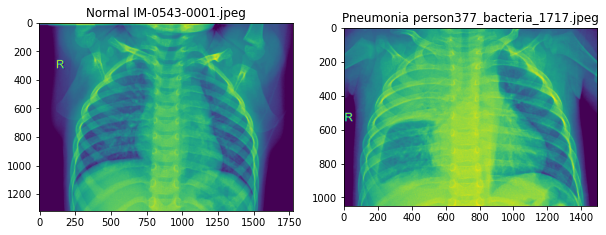

In [ ]:
# Set up folders for normal cases and pneumonia cases wihtin our train data
train_n = train_data_dir + '/NORMAL/'
train_p = train_data_dir + '/PNEUMONIA/'

# Random normal picture from train set
print(f"Normal X-Rays From Validation Set: {len(os.listdir(train_n))} ")

## Select 10 normal pictures
norm_pic = os.listdir(train_n)[25:35]
norm_pic_address = [train_n + pic for pic in norm_pic]

# Random Pneumonia picture from train set
print(f"Pneumonia X-Rays From Validation Set: {len(os.listdir(train_p))} ")

## Select 10 Pneumonia pictures
pneumonia_pic =  os.listdir(train_p)[40:50]
pneumonia_address = [train_p + pic for pic in pneumonia_pic]

for i in range(0,10):
    # Load the images
    norm_img = Image.open(norm_pic_address[i])
    pneumonia_img = Image.open(pneumonia_address[i])

    #Let's plt these images
    ## plot normal picture
    f = plt.figure(figsize= (10,6))
    a1 = f.add_subplot(1,2,1)
    img_plot = plt.imshow(norm_img)
    a1.set_title(f'Normal {norm_pic[i]}')

    ## plot pneumonia picture
    a2 = f.add_subplot(1, 2, 2)
    img_plot = plt.imshow(pneumonia_img)
    a2.set_title(f'Pneumonia {pneumonia_pic[i]}')

As we see there is a large bias towards Pneumonia data in the training set, only 25% of the data is normal data. If we built a classifier which would always label our data 1 we still would obtain a 75% accuracy. So we want to think about this, looking at false negatives is probably more informative of the model's performance. One way to deal with this issue is by adding class weights in to the layers.

### 2. Prepare the model

#### 2.1 Prepare the data

There are no files in the validation folder as we have it right now. To generate validation samples we do the following:  
Split training data into train and validation (80:20) sets. To perform this specify validation_split parameter in ImageDataGenerator function. Set directory path to training directory so that the Generator can take data from training directory.
Test generator Shuffle is set to FALSE. This is because, after predictions we want to plot our predictions to a Confusion Matrix and we want to be able to have one-one direct mapping of unshuffled samples.

In [ ]:
#  Create a data augmentor
data_augmentor = ImageDataGenerator(samplewise_center=True, rescale=1./255, shear_range=0.2,zoom_range = 0.2,samplewise_std_normalization=True,validation_split=0.2) 

# Set hyperparameters
target_size = (128,128)   
target_dims = (128, 128, 3) # add channel for RGB
n_batch_size = 32 

# Create datasets
train_generator = data_augmentor.flow_from_directory(train_data_dir,  target_size=target_size, subset='training',batch_size= n_batch_size,class_mode='binary')
val_generator = data_augmentor.flow_from_directory(train_data_dir, target_size=target_size,subset='validation',class_mode='binary')
test_generator = data_augmentor.flow_from_directory(test_data_dir, target_size=target_size,batch_size= 1,class_mode=None, shuffle=False)

Found 3716 images belonging to 2 classes.
Found 928 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### 2.2 Build the model

Here we create the structure of our model, we use the following layers:

In [ ]:
def initialize_model(name):    
    model = Sequential(name=name)
    
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=target_dims, padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
        
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(Dropout(0.1))
    
    model.add(layers.Flatten())    
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
model = initialize_model(name="basemodel")
model.summary()

Model: "basemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0 

In [ ]:
def compile_model(model):
    model.compile(optimizer="adam",loss='binary_crossentropy',metrics="binary_accuracy")
    return model

#### 2.3 Regularization

In order to prevent our model to overtrain we implement the following regularization measures. 

In [ ]:
model_baseline = initialize_model(name="baseline")
history_baseline = compile_model(model_baseline)

callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor=0.5, verbose=1),
            ModelCheckpoint("xray_model_v2.h5",save_best_only=True)]

### 3. Train the model

Now it's time to train our model!!

In [ ]:
history_baseline = model_baseline.fit(train_generator,
                                      batch_size=n_batch_size,
                                      epochs=10,
                                      validation_data=val_generator,shuffle=True,
                                      callbacks=callback) #,class_weight=class_weights)

Epoch 1/10
117/117 [==============================] - 1063s 9s/step - loss: 0.3476 - binary_accuracy: 0.8453 - val_loss: 0.2082 - val_binary_accuracy: 0.9224 - lr: 0.0010
Epoch 2/10
117/117 [==============================] - 69s 594ms/step - loss: 0.1954 - binary_accuracy: 0.9206 - val_loss: 0.2045 - val_binary_accuracy: 0.9149 - lr: 0.0010
Epoch 3/10
117/117 [==============================] - 68s 579ms/step - loss: 0.1516 - binary_accuracy: 0.9413 - val_loss: 0.1726 - val_binary_accuracy: 0.9386 - lr: 0.0010
Epoch 4/10
117/117 [==============================] - 67s 572ms/step - loss: 0.1477 - binary_accuracy: 0.9521 - val_loss: 0.1404 - val_binary_accuracy: 0.9515 - lr: 0.0010
Epoch 5/10
117/117 [==============================] - 67s 571ms/step - loss: 0.1438 - binary_accuracy: 0.9486 - val_loss: 0.1443 - val_binary_accuracy: 0.9472 - lr: 0.0010
Epoch 6/10
117/117 [==============================] - 67s 576ms/step - loss: 0.1279 - binary_accuracy: 0.9513 - val_loss: 0.1298 - val_binary

### 4. Evaluate the model

In [ ]:
scores = model_baseline.evaluate(val_generator)
scores

29/29 [==============================] - 13s 459ms/step - loss: 0.1094 - binary_accuracy: 0.9601


[0.10940980911254883, 0.9601293206214905]

Evaluate the model by looking at a graph

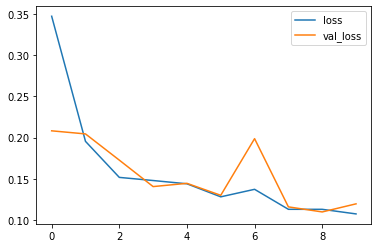

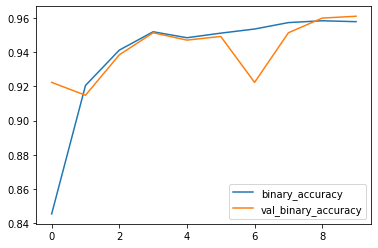

In [ ]:
history_frame = pd.DataFrame(history_baseline.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
model.save("model.h5")